In [1]:
# Import required packages
from os import path 
import time
from datetime import datetime
import numpy as np
import pandas as pd
import torch
from torch import nn, Tensor
from torch.optim import AdamW
from tqdm import tqdm, trange
import zuko
from zuko.flows import Distribution, NSF
from zuko.distributions import DiagNormal, BoxUniform, Minimum
from zuko.flows import DistributionModule, FlowModule, Unconditional
from hnne import HNNE

from utils.settings import config
from utils.utils import *
from utils.model import *
from utils.robot import Robot
from utils.dataset import create_dataset

In [2]:
panda = Robot(verbose=False)
# data generation
X, y = load_data(robot=panda, num_samples=config.num_train_size)
# build dimension reduction model
hnne = get_hnne_model(X, y)
# get loader
loader = get_loader(X, y, hnne=hnne)
# get val loader
val_loader = get_val_loader(robot=panda, hnne=hnne)
# Build Generative model, NSF
# Neural spline flow (NSF) with 3 sample features and 5 context features
flow, optimizer, scheduler = get_flow_model()

hnne load successfully from ./weights/panda/hnne.pickle
Model load successfully from ./weights/panda/nsf.pth


In [3]:
hnne.hierarchy_parameters.partition_sizes

[666996, 167574, 41230, 9867, 2387, 576, 142, 34, 11, 5]

In [4]:
hnne.hierarchy_parameters.partitions

array([[     0,      0,      0, ...,      0,      0,      0],
       [     1,      1,      1, ...,      1,      1,      1],
       [     2,      2,      2, ...,      2,      2,      2],
       ...,
       [ 78954,  62692,  32362, ...,      6,      5,      4],
       [292624,  29766,  21100, ...,      4,      1,      1],
       [230422,  68828,   6710, ...,     32,     10,      4]], dtype=int32)

In [5]:
label = hnne.hierarchy_parameters.partitions[:, -2]
label

array([ 0,  1,  2, ...,  5,  1, 10], dtype=int32)

In [6]:
data = np.column_stack((X, label))

In [7]:
df = pd.DataFrame(data=data, columns=[f'jt_{i}' for i in range(7)] + ['ml'])

array([[<AxesSubplot: title={'center': 'jt_0'}, xlabel='[ml]'>,
        <AxesSubplot: title={'center': 'jt_1'}, xlabel='[ml]'>],
       [<AxesSubplot: title={'center': 'jt_2'}, xlabel='[ml]'>,
        <AxesSubplot: title={'center': 'jt_3'}, xlabel='[ml]'>],
       [<AxesSubplot: title={'center': 'jt_4'}, xlabel='[ml]'>,
        <AxesSubplot: title={'center': 'jt_5'}, xlabel='[ml]'>],
       [<AxesSubplot: title={'center': 'jt_6'}, xlabel='[ml]'>,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

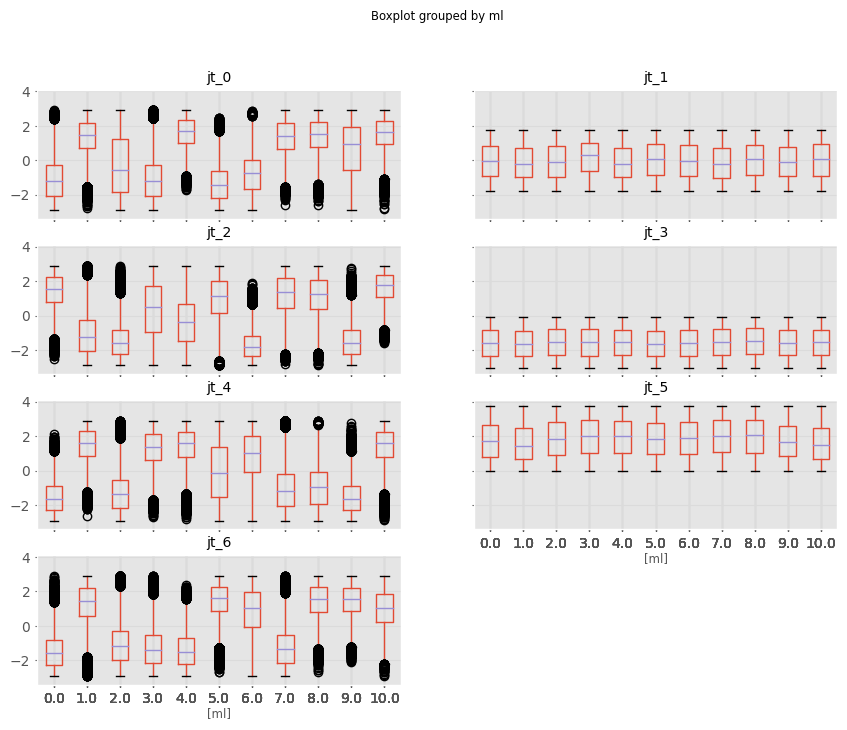

In [8]:
df.boxplot(by='ml', figsize=(10, 10), layout=(5, 2), fontsize=10)

In [9]:
x_trans = load_numpy(file_path=config.x_trans_train_path)
data = np.column_stack((x_trans, label))
df_trans = pd.DataFrame(data=data, columns=[i for i in range(4)] + ['ml'])

array([[<AxesSubplot: title={'center': '0'}, xlabel='[ml]'>,
        <AxesSubplot: title={'center': '1'}, xlabel='[ml]'>],
       [<AxesSubplot: title={'center': '2'}, xlabel='[ml]'>,
        <AxesSubplot: title={'center': '3'}, xlabel='[ml]'>],
       [<AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

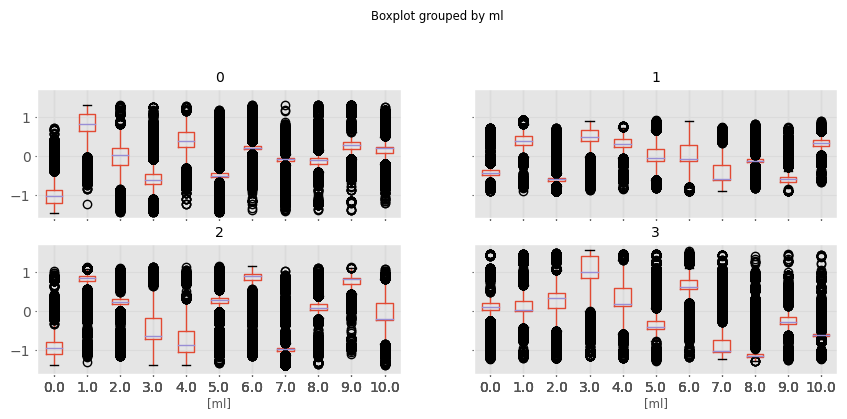

In [10]:
df_trans.boxplot(by='ml', figsize=(10, 10), layout=(5, 2), fontsize=10)

In [11]:
for i in range(4):
    print(df_trans.groupby('ml')[i].describe())

         count      mean       std       min       25%       50%       75%  \
ml                                                                           
0.0   142465.0 -0.980770  0.317359 -1.456932 -1.205445 -1.028474 -0.874855   
1.0   155843.0  0.840213  0.263310 -1.233100  0.632532  0.829781  1.066660   
2.0   345249.0 -0.006217  0.240341 -1.453273 -0.226776  0.029261  0.194445   
3.0   398205.0 -0.605651  0.173947 -1.446041 -0.724594 -0.615670 -0.470099   
4.0   174157.0  0.413880  0.223533 -1.242751  0.239105  0.377710  0.602812   
5.0   369423.0 -0.465481  0.126251 -1.444846 -0.533847 -0.504110 -0.443687   
6.0   224572.0  0.235960  0.163658 -1.384256  0.170127  0.206039  0.250595   
7.0   211164.0 -0.070937  0.160727 -1.402869 -0.120357 -0.085887 -0.050672   
8.0   193521.0 -0.132370  0.129406 -1.387388 -0.197985 -0.104992 -0.059662   
9.0   176021.0  0.277163  0.157410 -1.386917  0.187342  0.280753  0.358543   
10.0  109380.0  0.138859  0.172746 -1.216201  0.065162  0.205395

In [12]:
for i in range(7):
    print(df.groupby('ml')[f'jt_{i}'].describe())

         count      mean       std       min       25%       50%       75%  \
ml                                                                           
0.0   142465.0 -1.108408  1.117867 -2.897271 -2.051412 -1.178595 -0.275462   
1.0   155843.0  1.374556  1.003429 -2.740736  0.707321  1.493175  2.190660   
2.0   345249.0 -0.293355  1.724088 -2.897285 -1.811737 -0.562608  1.247071   
3.0   398205.0 -1.023757  1.278833 -2.897294 -2.047767 -1.196777 -0.240657   
4.0   174157.0  1.617795  0.838976 -1.703196  1.023654  1.715945  2.314968   
5.0   369423.0 -1.353696  0.992823 -2.897264 -2.185147 -1.455024 -0.626429   
6.0   224572.0 -0.783088  1.116138 -2.897270 -1.655592 -0.728906  0.042155   
7.0   211164.0  1.373450  0.947174 -2.573008  0.676452  1.442838  2.160238   
8.0   193521.0  1.446602  0.933865 -2.583541  0.777056  1.532516  2.226668   
9.0   176021.0  0.616286  1.609660 -2.897293 -0.538603  0.958274  1.946642   
10.0  109380.0  1.537744  0.892763 -2.804822  0.921862  1.640911